In [91]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [92]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [93]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from datetime import datetime, timedelta

In [94]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///C:/Users/ericg/Downloads/Starter_Code_Hawii/Starter_Code/Resources/hawaii.sqlite")


In [95]:
import os.path

database = 'C:/Users/ericg/Downloads/Starter_Code_Hawii/Starter_Code/Resources/hawaii.sqlite'
if not os.path.exists(database):
    raise ValueError(f'Invalid database path: {database}')



In [96]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [97]:
# View all of the classes that automap found
# Print all classes mapped to the Base
for class_ in dir(Base.classes):
    print(class_)


__class__
__delattr__
__dir__
__doc__
__eq__
__format__
__ge__
__get__
__getattribute__
__getstate__
__gt__
__hash__
__init__
__init_subclass__
__le__
__lt__
__ne__
__new__
__reduce__
__reduce_ex__
__repr__
__self__
__self_class__
__setattr__
__sizeof__
__str__
__subclasshook__
__thisclass__
measurement
station


In [98]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station


In [99]:
# Create our session (link) from Python to the DB
from sqlalchemy.orm import Session
session = Session(engine)

# Exploratory Precipitation Analysis

In [100]:
# Find the most recent date in the data set.
from sqlalchemy import desc

most_recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()

(f"The most recent date it: {most_recent_date[0]}")

'The most recent date it: 2017-08-23'

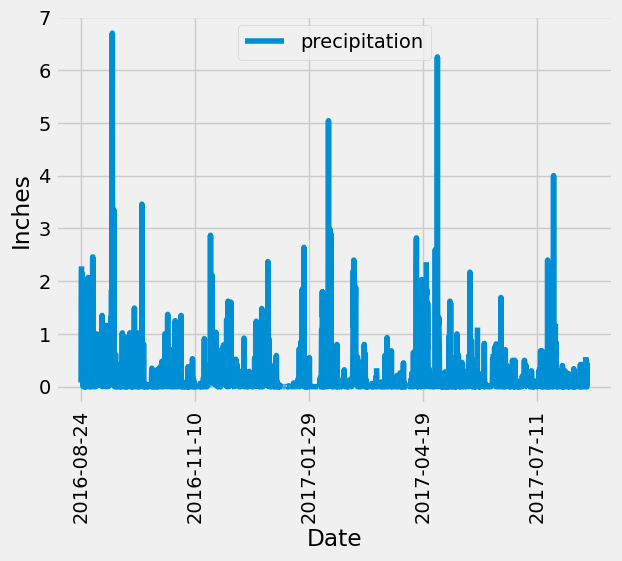

In [101]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent_date = session.query(Measurement.date).order_by(desc(Measurement.date)).first()[0]
most_recent_date = datetime.strptime(most_recent_date, '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
one_year_ago = most_recent_date - timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= one_year_ago).\
    order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns=['date', 'precipitation'])
df.set_index('date', inplace=True)

# Sort the dataframe by date
df = df.sort_index()

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.show()

In [102]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary= df['precipitation'].describe()
summary

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [103]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(Station).count()
(f"Total number of stations: {total_stations}")

'Total number of stations: 9'

In [104]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc()).all()

for station, count in active_stations:
    print(f"Station: {station}, Count: {count}")


Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [105]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]

# Calculate the lowest, highest, and average temperature
lowest_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
highest_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == most_active_station).scalar()

print(f"Most Active Station: {most_active_station}")
print(f"Lowest Temperature: {lowest_temp}")
print(f"Highest Temperature: {highest_temp}")
print(f"Average Temperature: {avg_temp}")

Most Active Station: USC00519281
Lowest Temperature: 54.0
Highest Temperature: 85.0
Average Temperature: 71.66378066378067


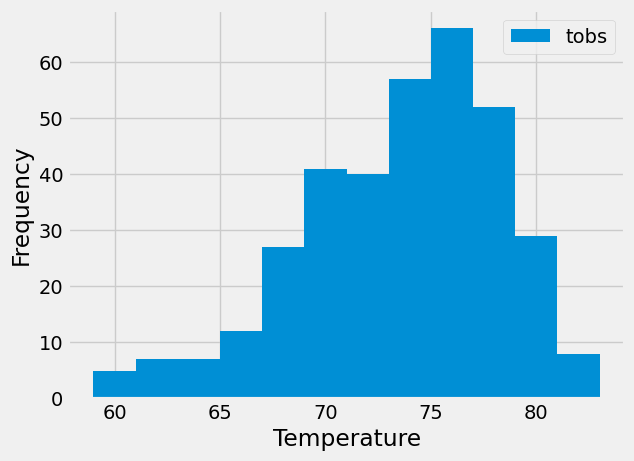

In [106]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results = session.query(Measurement.tobs).\
    filter(Measurement.station == most_active_station).\
    filter(Measurement.date >= one_year_ago).all()

# Convert the results to a DataFrame
df = pd.DataFrame(results, columns=['tobs'])

# Plot the results as a histogram
df.plot.hist(bins=12)
plt.xlabel("Temperature")
plt.show()


# Close Session

In [110]:
# Close Session
session.close()